In [1]:
%load_ext notexbook
%load_ext watermark

In [2]:
%texify

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/deep-unsupervised-learning/HEAD?filepath=2_Clustering/HDBSCAN%20Algorithm.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/deep-unsupervised-learning/blob/main/2_Clustering/HDBSCAN%20Algorithm.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/deep-unsupervised-learning/blob/main/2_Clustering/HDBSCAN%20Algorithm.ipynb)
</span>

<span class="texbook-turquoise">**Source**</span> <br />This notebook has been adapted from the _brilliant_ introductory notebook by `@lmcinnes` entitled 
<span class="texbook-turquoise"><ins>How HDBSCAN Works</ins></span> ([original version](https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb))

# How HDBSCAN Works

`HDBSCAN` is a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). 

`HDBSCAN` extends `DBSCAN` by converting it into a <ins>hierarchical clustering algorithm</ins>, and then using a technique to extract a <ins>flat clustering</ins> based on the **stability** of generated clusters. 

The goal of this notebook is to give an overview of how the algorithm works, and the motivations behind it. 

Similarly to the [original notebook](https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb), `HDBSCAN` will be examined from an algorithmic perspective, in order to emphasise the actual clustering procedure, rather than comparing it directly with `DBSCAN`.
In more details, the algorithm of the HDBSCAN will be described as composed by two main steps: (1) a [Robust Single Linkage](http://cseweb.ucsd.edu/~dasgupta/papers/tree.pdf), and (2) [Flat cluster extraction](http://link.springer.com/article/10.1007%2Fs10618-013-0311-4).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import hdbscan
%matplotlib inline

sns.set_context("notebook")
sns.set_style("white")
sns.set_color_codes()
plot_kwds = {"alpha" : 0.5, "s" : 80, "linewidths":0}
plt.style.use("seaborn-white")
%watermark -iv

sklearn   : 0.24.1
numpy     : 1.20.2
matplotlib: 3.4.1
seaborn   : 0.11.1
hdbscan   : 0.8.27



## Dataset

We will generate data of a fairly small size, in order to be able to investigate what is going on during the clustering process. At the same time, it would be also useful to have several clusters, preferably of different kinds. 

To do so, we will be using `sklearn` data generation methods (i.e. `make_moons` and `make_blobs`), that will be then combined together to generate a unique reference dataset to use for clustering. 

In [4]:
# setting random state for replicability of selections
SEED = 123456

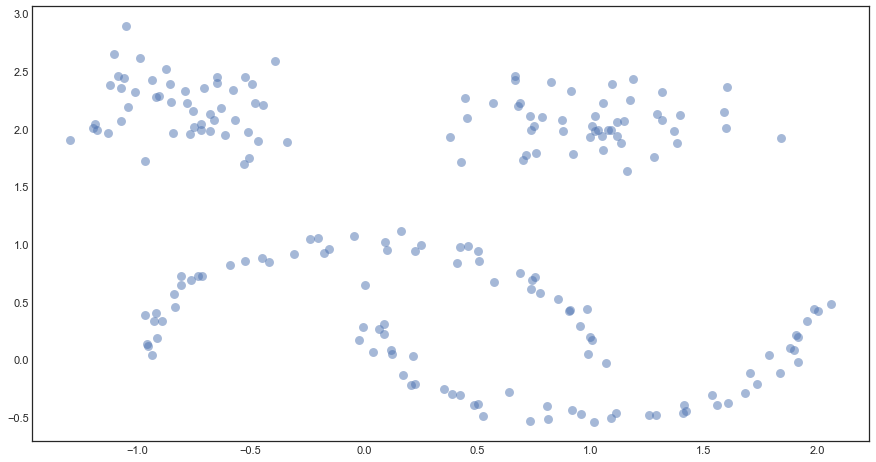

In [5]:
moons, _ = data.make_moons(n_samples=100, noise=0.05, random_state=SEED)
blobs, _ = data.make_blobs(n_samples=100, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25, random_state=SEED)
test_data = np.vstack([moons, blobs])
plt.figure(figsize=(15, 8))
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)
plt.show()

## Cluster with `hdbscan`

Now, the best way to explain HDBSCAN is actually by just running the algorithm, and then go through the steps that occurred along the way, describing in details the purpose (and output) of each step. 

Doing so will be also quite easy thanks to the API of the `HDBSCAN` object that exposes the exact steps we are interested to describe, and dwell into (see `gen_min_span_tree=True` parameter) 

Last but not least, it is important to emphasise that `hdbscan` API are entirely compliant with `sklearn.Estimator` API which makes the [library](https://github.com/scikit-learn-contrib/hdbscan) a perfect fit within `sklearn-contrib` packages.

In [6]:
# HyperParams: min_cluster_size=5; 
# gen_min_span_tree=True ==> we require to store the generated Minimum Spanning Tree during cluster computation
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

So now that we have clustered the data -- what actually happened? We can break it out into a series of steps

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

### 1. Transform the space

To find clusters we want to find the islands of higher density amid a sea of sparser noise -- and the **assumption of noise** is important: _real data is messy and has outliers, corrupt data, and noise_. 

The core of the clustering algorithm is **Single linkage** clustering, which can be quite sensitive to noise: a single noise data point in the wrong place can act as a bridge between islands, gluing them together. 

Obviously we want our algorithm to be **robust** against noise so we need to find a way to help _lower the sea level_ before running a Single linkage algorithm.

The question now is: **"How can we characterize `sea` and `land` without doing a clustering?"**

As long as we can get an estimate of **density**, we can consider lower density points as the `sea`. 

The goal here is not to perfectly distinguish `sea` from `land` -- _this is an initial step in clustering, not the ouput_ -- just to make our clustering core a little more robust to noise. So given an identification of `sea`, we want to lower the sea level. For practical purposes that means making `sea` points more distant from each other and from the `land`.

That's just the intuition, but **how does it work in practice?**

We need a very _inexpensive_ estimate of **density**, and the simplest is the distance to the **K-th Nearest Neighbour**.

If we have the `Distance Matrix` for our data (_which we will need anyway to actually perform the clustering_) we can simply read that off; alternatively if our `metric` is supported (_and dimension is low, ed._) this is the sort of query that [`KD-Trees`](http://scikit-learn.org/stable/modules/neighbors.html#k-d-tree) are good for[1](#fn1). 

Let's formalise this and (with analogies with `DBSCAN` and `HDBSCAN` terminology) let's call it the **core distance**.
The core distance for a generic data point `x` is defined by a parameter `k`, and it is denoted as 
<span class="inline-math">$$\mathrm{core}_k(x)$$</span> 

Now we need a way to spread apart points with **low density**, i.e. _high core distance_. 

The simple way to do this is to define a **new** distance metric between points which we will call (again, aligning with the literature) the _Mutual Reachability Distance_.  

The _Mutual Reachability Distance_ is defined as follows:

$$ d_{\mathrm{mreach}_{k}}(a,b) = \max \{\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b) \}$$

where <span class="inline-math">$$ d(a,b) $$</span> is the original metric distance between $a$ and $b$. 


Under this metric, _dense_ points (having _low_ $\mathrm{core}$ distance) remain the same distance from each other, whereas _sparser_ points are "pushed away" to be at least their core distance away from any other point. This effectively _lowers the sea level_, spreading sparse `sea` points out, while leaving `land` untouched. The caveat here is that _obviously_ this is dependent upon the choice of `k`: larger `k` values interpret more points as being in the `sea`. 

<span id="fn1">**[1]**: Determining the _neighbourhood_ of data points is actually a very interesting topic from an algorithmic perspective. For this reason, I do highly recommend to check out the whole [article](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors) on the subject in `sklearn` documentation (_ed._)</span>

#### Mutual Reachability in Practice

To better understand the idea behing the _Mutual Reachability_ metric, as well as the effects of choosing different values for `k`, let's try to calculate the value of the metric for our `test_data`. For simplicity, let's just focus on the samples in selected area:

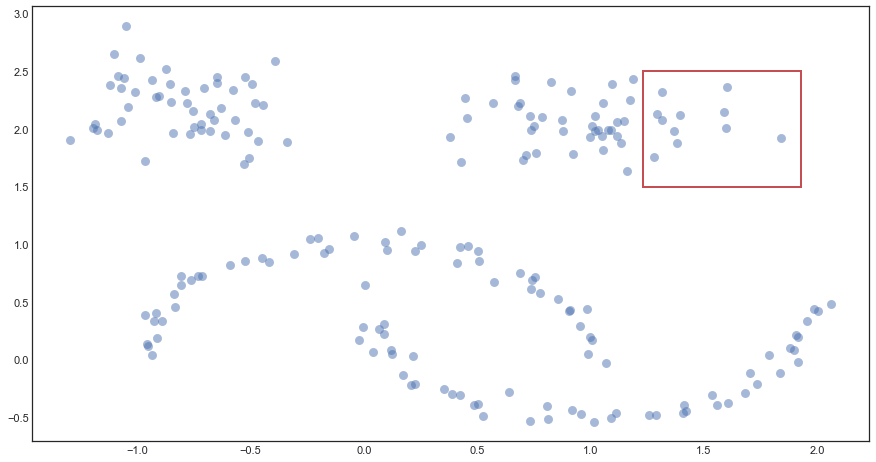

In [7]:
from matplotlib import patches

fig, ax = plt.subplots(figsize=(15, 8))
rect = patches.Rectangle((1.23, 1.5), 0.7, 1, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)
ax.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)
plt.show()

In [8]:
x_lim = (1.23, 1.93)
y_lim = (1.5, 2.5)
x_sel = (test_data.T[0] >= x_lim[0]) & (test_data.T[0] <= x_lim[1])
y_sel = (test_data.T[1] >= y_lim[0]) & (test_data.T[1] <= y_lim[1])

sample_selection = test_data[x_sel & y_sel]
print("Nr. samples selected: ", sample_selection.shape[0])

Nr. samples selected:  11


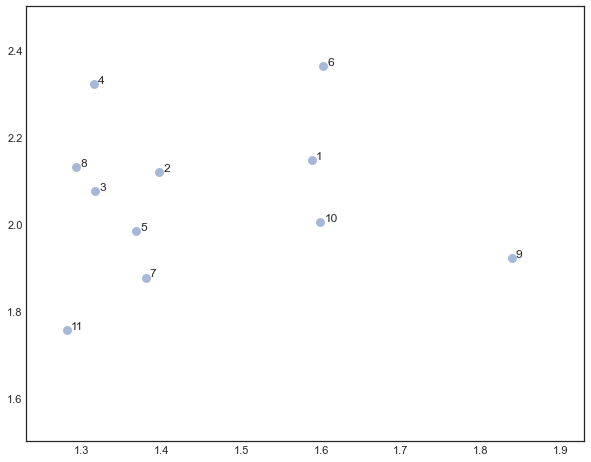

In [9]:
def plot(data, xlim=x_lim, ylim=y_lim, figsize=None, plot_opts=plot_kwds):
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(data.T[0], data.T[1], color='b', **plot_opts)
    for i in range(data.shape[0]):
        ax.annotate(i+1, (data[i, 0]+0.005, data[i, 1]+0.002))
    
    if xlim is not None and ylim is not None:
        plt.setp(ax, xlim=xlim, ylim=ylim)
    return fig, ax

_ = plot(sample_selection, figsize=(10, 8))
plt.show()

In this example, let's considers **three samples** (i.e. `1`, `6`, and `9` in the above picture) and try calculate first their corresponding $\mathrm{core}$ distance.

To do so, we need to calculate their neighbourhoods (using `sklearn.neighbors.KDTree`):

In [10]:
from sklearn.neighbors import KDTree

tree = KDTree(sample_selection, leaf_size=3)

Let's now determine the neighbourhood of selected points with `k = 6`

**Note**: Remember that the closest in a point's neighbourhood is always the point itself ($d_{i,i} = 0$ by definition).
<br />
Therefore, by choosing a value of `k = 6` we will select the `5` nearest neighbours of a given point. 

In [11]:
# The function will return the distances, and indices of samples for each neighbourhood.
# That is a matrix of shape (11 x 6), i.e. (samples x k)
dist, ind = tree.query(sample_selection, k=6)

In [12]:
dist.shape, ind.shape

((11, 6), (11, 6))

For a given point, we can draw a _circle_ for the core distance as the circle that touches the `6` nearest neighbor (counting the point itself), like so:

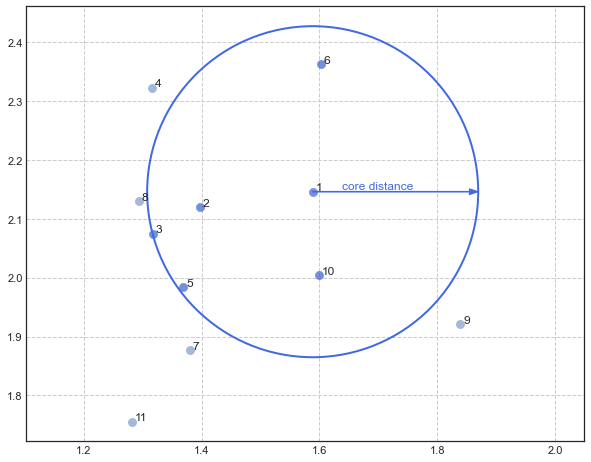

In [13]:
def plot_neighbours(ax, centre, points, radius, colour, marker=".", colour_points=True, plot_opts=plot_kwds):
    circle = plt.Circle((centre[0], centre[1]), radius=radius, linewidth=2, 
                        edgecolor=colour, fill=False)
    
    scatter_opts = {} if plot_opts is None else {k:v for k,v in plot_opts.items()}
    scatter_opts["color"] = colour if colour_points else "b" 
    ax.scatter(points.T[0, :], points.T[1, :], marker=marker, **scatter_opts)
    ax.arrow(centre[0], centre[1], radius, 0, color=colour, 
             length_includes_head=True, head_width=0.01)
    ax.annotate("core distance", (centre[0]+0.05, centre[1]+0.005), c=colour)
    ax.add_patch(circle)

fig, ax = plot(sample_selection, xlim=None, ylim=None, figsize=(10, 8))
plot_neighbours(ax, centre=sample_selection[0], points=sample_selection[ind[0]], 
                radius=dist[0].max(), colour="royalblue", marker="8")
ax.set_aspect("equal", adjustable="datalim")
ax.grid(linestyle='--')

plt.show()

Let's now proceed by adding the neighbourhood of 2nd point, repeating the process with its corresponding set of neighbours:

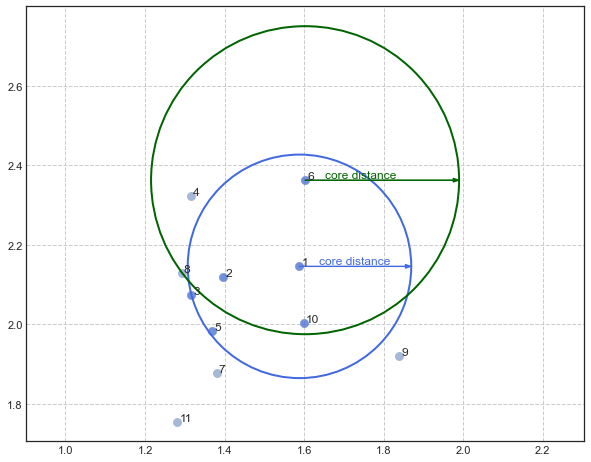

In [14]:
fig, ax = plot(sample_selection, xlim=None, ylim=None, figsize=(10, 8))
plot_neighbours(ax, centre=sample_selection[0], points=sample_selection[ind[0]], 
                radius=dist[0].max(), colour="royalblue", marker="8")
plot_neighbours(ax, centre=sample_selection[5], points=sample_selection[ind[5]], 
                radius=dist[5].max(), colour="darkgreen", marker="x")
ax.set_aspect("equal", adjustable="datalim")
ax.grid(linestyle='--')

plt.show()

And we can do that a third time for good measure, with another set of six nearest neighbours and another circle with slightly different radius again.


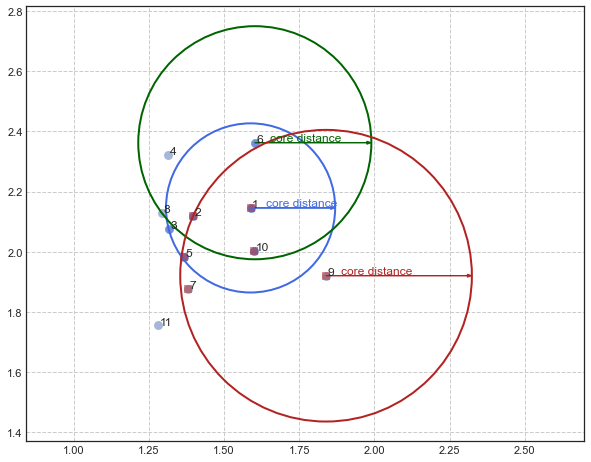

In [15]:
fig, ax = plot(sample_selection, xlim=None, ylim=None, figsize=(10, 8))
plot_neighbours(ax, centre=sample_selection[0], points=sample_selection[ind[0]], 
                radius=dist[0].max(), colour="royalblue", marker="8")
plot_neighbours(ax, centre=sample_selection[5], points=sample_selection[ind[5]], 
                radius=dist[5].max(), colour="darkgreen", marker="x")
plot_neighbours(ax, centre=sample_selection[8], points=sample_selection[ind[8]], 
                radius=dist[8].max(), colour="firebrick", marker="s")
ax.set_aspect("equal", adjustable="datalim")
ax.grid(linestyle='--')

plt.show()

**To summarise**, we have calculated the following $\mathrm{core}$ distances:

In [16]:
core_1 = dist[0].max()
core_6 = dist[5].max()
core_9 = dist[8].max()

print(f"core_1 = {core_1:.2f} (blue)\ncore_6 = {core_6:.2f} (green) \ncore_9 = {core_9:.2f} (red) ")

core_1 = 0.28 (blue)
core_6 = 0.39 (green) 
core_9 = 0.48 (red) 


Now if we want to know the **mutual reachability** distance between samples `1` and `6` we can start by drawing in an arrow giving the distance between <span style="color: blue">blue</span> and <span style="color: green">green</span> dots in the figure:

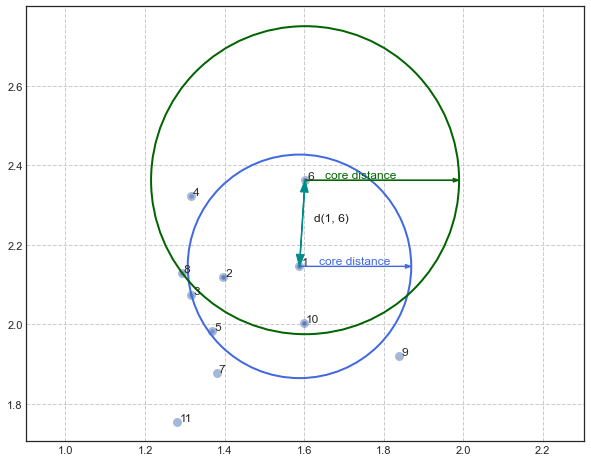

In [17]:
def draw_distance(ax, sample_1, sample_2, colour="darkcyan", label="d(*, *)"):
    l = sample_2 - sample_1
    m = (sample_2 + sample_1) / 2
    ax.arrow(sample_1[0], sample_1[1], dx=l[0], dy=l[1], linewidth=1, 
             length_includes_head=True, head_width=0.02, color=colour)
    ax.arrow(sample_2[0], sample_2[1], dx=-l[0], dy=-l[1], linewidth=1,
             length_includes_head=True, head_width=0.02, color=colour)
    ax.annotate(label, (m[0]+0.03, m[1]+0.005), c="k")

fig, ax = plot(sample_selection, xlim=None, ylim=None, figsize=(10, 8))
plot_neighbours(ax, centre=sample_selection[0], points=sample_selection[ind[0]], 
                radius=dist[0].max(), colour="royalblue", colour_points=False, plot_opts=plot_kwds)
plot_neighbours(ax, centre=sample_selection[5], points=sample_selection[ind[5]], 
                radius=dist[5].max(), colour="darkgreen", colour_points=False, plot_opts=plot_kwds)

draw_distance(ax, sample_selection[0], sample_selection[5], label="d(1, 6)")

ax.set_aspect("equal", adjustable="datalim")
ax.grid(linestyle='--')

plt.show()

The two points are actually quite close, as the distance vector does not passes through neither the <span style="color: blue">blue</span> nor the <span style="color: green">green</span> circles[2](#fn2). In this case, the $\mathrm{core}$ distance for <span style="color: green">green</span> is larger than the distance between <span style="color: blue">blue</span> and <span style="color: green">green</span>. 

Therefore we need to mark the **mutual reachability** <span class="inline-math">$$d_{\mathrm{mreach}_{k = 6}} (1,6)$$</span> distance between <span style="color: blue">blue</span> and <span style="color: green">green</span> as equal to the radius of the <span style="color: green">green</span> circle.

<span id="fn2">**[2]**: This method of counting how many circles the distance vector passes through can be used as a practical strategy to determine whether the distance is larger than any $\mathrm{core}$.</span>

As a matter of facts:

In [18]:
from scipy.spatial.distance import euclidean

d_1_6 = euclidean(sample_selection[0], sample_selection[5])
mreach_distances_16 = {"core_1": core_1, "core_6": core_6, "d_1_6": d_1_6}
mreach_16 = max(mreach_distances_16, key=lambda k: mreach_distances_16[k])
print(f"mreach(1, 6) = {mreach_16} ({mreach_distances_16[mreach_16]:.2f})")

mreach(1, 6) = core_6 (0.39)


On the other hand, the **mutual reachablity** distance from <span style="color: red">red</span> to <span style="color: green">green</span> is simply the distance from <span style="color: red">red</span> to <span style="color: green">green</span> since that distance is greater than either core distance (i.e. the distance arrow passes through both circles).

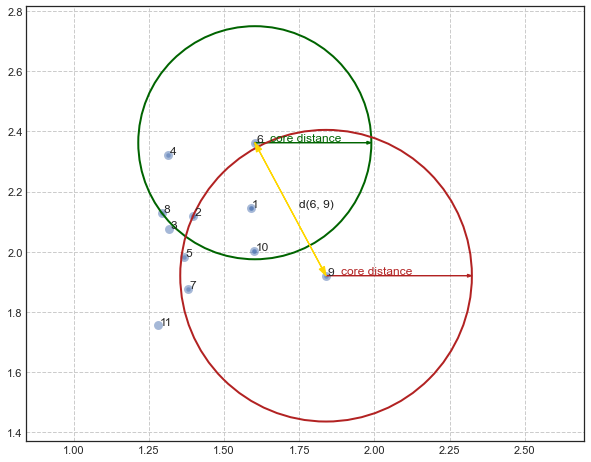

In [19]:
fig, ax = plot(sample_selection, xlim=None, ylim=None, figsize=(10, 8))
plot_neighbours(ax, centre=sample_selection[5], points=sample_selection[ind[5]], 
                radius=dist[5].max(), colour="darkgreen", colour_points=False, plot_opts=plot_kwds)
plot_neighbours(ax, centre=sample_selection[8], points=sample_selection[ind[8]], 
                radius=dist[8].max(), colour="firebrick", colour_points=False, plot_opts=plot_kwds)

draw_distance(ax, sample_selection[5], sample_selection[8], label="d(6, 9)", colour="gold")

ax.set_aspect("equal", adjustable="datalim")
ax.grid(linestyle='--')

plt.show()

Cross Check:

In [20]:
d_6_9 = euclidean(sample_selection[5], sample_selection[8])
mreach_distances_69 = {"core_6": core_6, "core_9": core_9, "d_6_9": d_6_9}
mreach_69 = max(mreach_distances_69, key=lambda k: mreach_distances_69[k])
print(f"mreach(6, 9) = {mreach_69} ({mreach_distances_69[mreach_69]:.2f})")

mreach(6, 9) = d_6_9 (0.50)


In general there is [underlying theory](http://arxiv.org/pdf/1506.06422v2.pdf) to demonstrate that mutual reachability distance as a transform works well in allowing **single linkage clustering** to more closely approximate the hierarchy of level sets of whatever true density distribution our points were sampled from.

### 2. Build the Minimum Spanning Tree (`MSP`)

Now that we have a new **mutual reachability** metric on the data, we want start finding the islands on dense data. 

Of course dense areas are relative, and different islands may have different densities. Conceptually what we will do is the following: 

1. [**Data as a Weighed Graph**]: Consider the data as a _weighted (undirected) graph_ with data points being vertices, and an edge between any two points with weight equal to the mutual reachability distance of those points.

2. [**Edge drop on Threshold**]: Consider a `threshold` value, starting high, and steadily being lowered. **Drop** any edges with weight above that threshold. As we drop edges we will start to disconnect the graph into _connected components_. Eventually we will have a hierarchy of connected components (from _completely connected_ to _completely disconnected_) at varying `threshold` levels.

In practice, this operation might be very expensive: there are $n^2$ edges (_fully connected graph_), and we don't want to have to run a connected components algorithm that many times. 

The right thing to do is to find a _minimal set of edges such that dropping any edge from the set causes a disconnection of components_. But we need more, we need this set to be such that there is no lower weight edge that could connect the components. Fortunately graph theory furnishes us with just such a thing: the **minimum spanning tree** of the graph.

We can build the minimum spanning tree very efficiently via [Prim's algorithm](https://en.wikipedia.org/wiki/Prim%27s_algorithm)[3](#fn3). We build the tree one edge at a time, always adding the lowest weight edge that connects the current tree to a vertex not yet in the tree. 

You can see the tree HDBSCAN constructed below; note that this is the minimum spanning tree for *mutual reachability distance* which is different from the pure distance in the graph. In this case we had a *k* value of 6.

<span id="fn3">In the case that the data lives in a metric space we can use even faster methods, such as Dual Tree Boruvka to build the minimal spanning tree.</span>

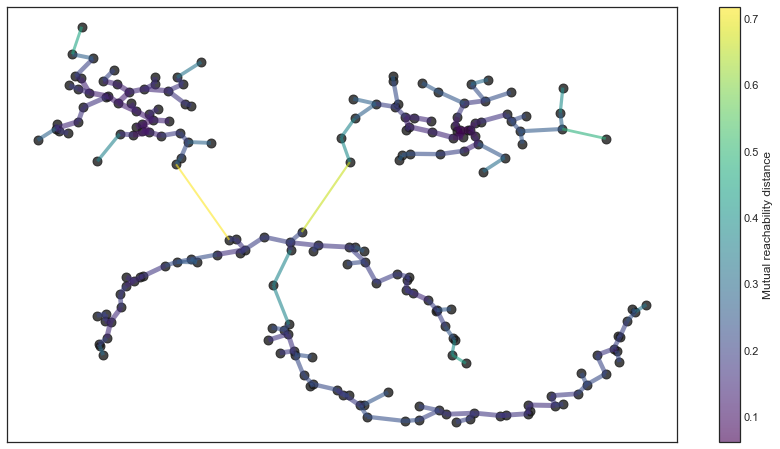

In [21]:
plt.figure(figsize=(15, 8))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)
plt.show()

### 3. Build the cluster hierarchy

Given the `MSP`, the next step is to convert that into the hierarchy of connected components. 

This is most easily done in the reverse order: 

1. Sort the edges of the tree by distance (in increasing order);
2. Iterate through edges, creating a new merged cluster for each edge. 

The only difficult part here is to identify the two clusters each edge will join together, but this is easy enough via a [union-find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) data structure. We can view the result as a dendrogram as we see below:

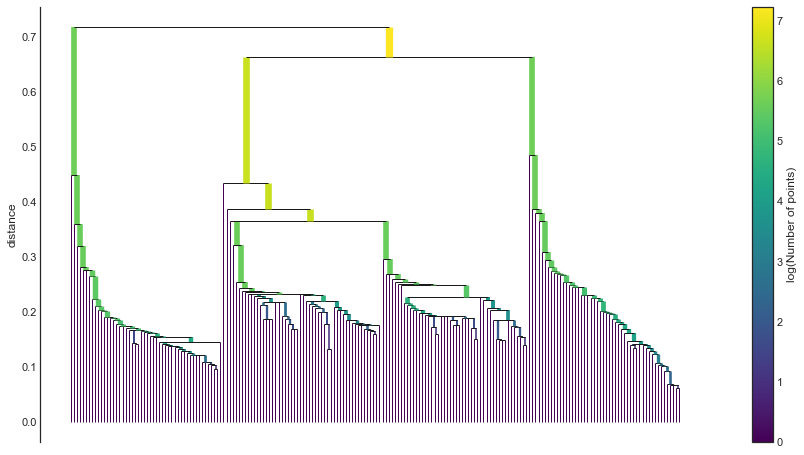

In [22]:
plt.figure(figsize=(15, 8))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

This brings us to the point where **robust single linkage** stops. 

#### We want more...

A cluster hierarchy is good, but we really want a set of _flat_ clusters instead. 

We could do that by drawing a horizontal line through the above diagram and selecting the clusters that it cuts through. This is in practice what [DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan) effectively does (declaring any singleton clusters at the cut level as _noise_). 

The question is, how do we know where to draw that line? `DBSCAN` simply leaves that as a (very unintuitive) parameter.

Worse, we really want to deal with variable density clusters and any choice of cut line is a choice of mutual reachability distance to cut at, and hence a single fixed density level. 

Ideally we want to be able to cut the tree at different places to select our clusters. This is where the next steps of `HDBSCAN` begin and create the difference from **robust single linkage**.

### 4. Condense the Cluster tree

The first step in (_flat_) cluster extraction is condensing down the large and complicated cluster hierarchy into a smaller tree with a little more data attached to each node. 

As you can see in the hierarchy above, it is often the case that _a cluster split is one or two points splitting off from a cluster_; and that is the **key point**: rather than seeing it as a cluster splitting into two new clusters, we want to view it as a single persistent cluster that is _losing points_. 

To implement this in practice, we need a notion of **minimum cluster size** which we take as a parameter to `HDBSCAN`. 

Once we have a value for minimum cluster size, we can now walk through the hierarchy and at each split ask if one of the new clusters created by the split has fewer points than the minimum cluster size. 

If it is the case that we have fewer points than the minimum cluster size, we declare it to be _points falling out of a cluster_ and have the larger cluster retain the cluster identity of the parent, marking down which points _fell out of the cluster_ and at what distance value that happened. 

If on the other hand the split is into two clusters each at least as large as the minimum cluster size, then we consider that a true cluster split and let that split persist in the tree. 

After walking through the whole hierarchy and doing this, we end up with a much smaller tree with a small number of nodes, each of which has data about how the size of the cluster at that node descreases over varying distance. 

We can visualize this as a dendrogram similar to the one above -- again we can have the width of the line represent the number of points in the cluster. This time, however, that width varies over the length of the line as points fall our of the cluster.

For our data using a minimum cluster size of 5 the result looks like this:

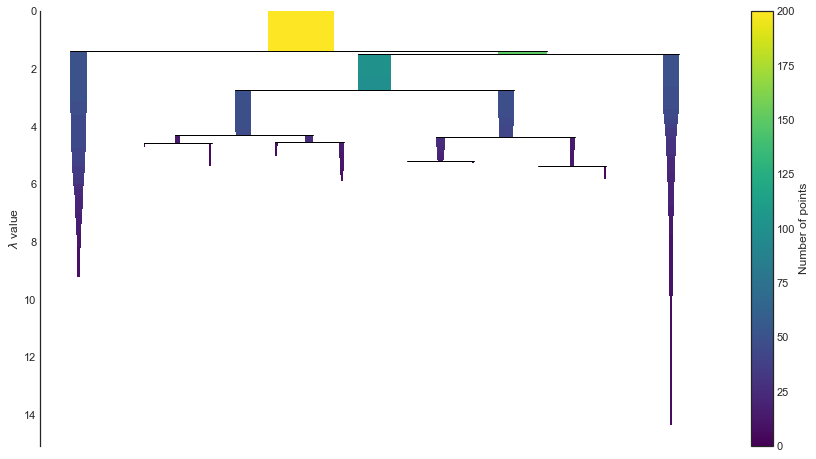

In [23]:
plt.figure(figsize=(15, 8))
clusterer.condensed_tree_.plot()
plt.show()

This is much easier to look at and deal with, particularly in as simple a clustering problem as our current test dataset. However we still need to pick out clusters to use as a **flat clustering**. 

(_Looking at the plot above should give you some ideas about how one might go about doing this_).

### 5. Extract the Clusters

Intuitively we want the choose clusters that persist and have a longer lifetime; short lived clusters are ultimately probably merely artifacts of the single linkage approach. 

Looking at the previous plot, we could say that we want to choose those clusters that have the **greatest** area of ink in the plot. 

To make a flat clustering we will need to add a further requirement that, if you select a cluster, then you cannot select any cluster that is a descendant of it. And in fact that intuitive notion of what should be done is exactly what `HDBSCAN` does. Of course we need to formalise things to make it a concrete algorithm.

First we need a different measure than distance to consider the persistence of clusters; instead we will use 
<span class="inline-math">$$\lambda = \frac{1}{\mathrm{distance}}$$</span>. 

For a given cluster, we can then define values $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ to be the `lambda` value when the cluster split off and became its own cluster, and the `lambda` value (if any) when the cluster split into smaller clusters, respectively. 

In turn, for a given cluster, for each point $p$ in that cluster, we can define the value $\lambda_p$ as the lambda value at which that point _fell out of the cluster_ which is a value somewhere between $\lambda_{\mathrm{birth}}$ and $\lambda_{\mathrm{death}}$ since the point either falls out of the cluster at some point in the cluster's lifetime, or leaves the cluster when the cluster splits into two smaller clusters. 

Now, for each cluster compute the **stability** to as

$$\sum_{p \in \mathrm{cluster}} (\lambda_p - \lambda_{\mathrm{birth}})$$.

Declare all `leaf` nodes to be selected clusters. Now work up through the tree (the **reverse topological sort order**). If the sum of the stabilities of the child clusters is greater than the stability of the cluster then we set the cluster stability to be the sum of the child stabilities. If, on the other hand, the cluster's stability is greater than the sum of its children then we declare the cluster to be a selected cluster, and unselect all its descendants. Once we reach the root node we call the current set of selected clusters our flat clsutering and return that.

#### More in practice

Okay, that was wordy and complicated, but it really is simply performing our _select the clusters in the plot with the largest total ink area_ subject to descendant constraints that we explained earlier. 

We can select the clusters in the condensed tree dendrogram via this algorithm, and you get what you expect:

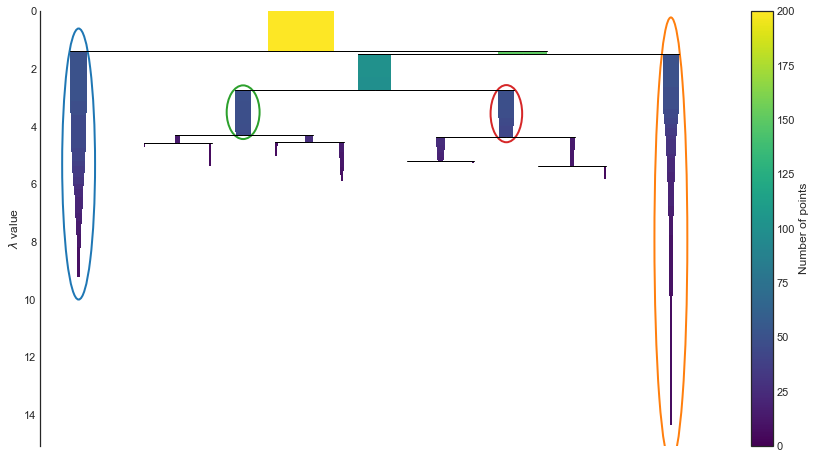

In [24]:
plt.figure(figsize=(15, 8))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

#### Final Remarks

Now that we have the clusters, it is a simple enough matter to turn that into cluster labelling as per the `sklearn API`. 

Any point **not in a selected cluster** is simply a _noise point_ (and assigned the label `-1`). 

We can do a little more though: for each cluster we have the $\lambda_p$ for each point $p$ in that cluster.

If we simply normalize those values (so they range from `zero` to `one`) then we have a measure of the strength of cluster membership for each point in the cluster. 

The `hdbscan` library returns this as a `probabilities_` attribute of the clusterer object. Thus, with labels and membership strengths in hand we can make the standard plot, choosing a color for points based on cluster label, and desaturating that color according the strength of membership (and make unclustered points pure gray).

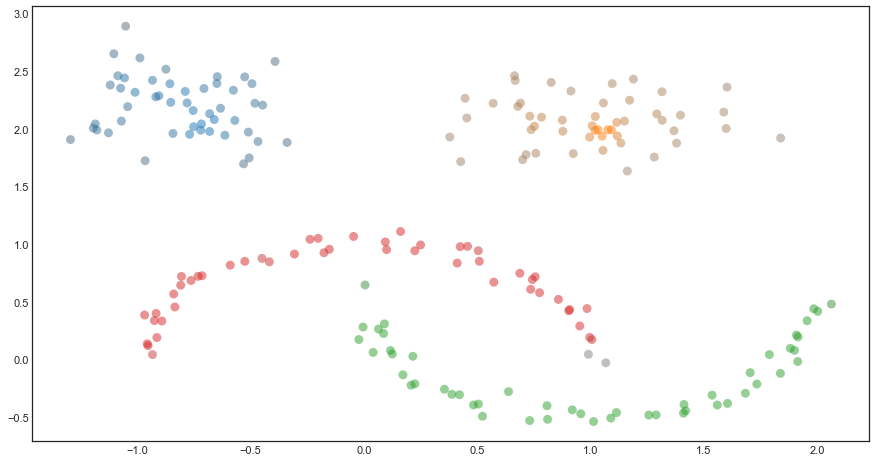

In [25]:
plt.figure(figsize=(15, 8))
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)
plt.show()

And that is how **HDBSCAN** works. 

It may seem somewhat complicated -- there are a fair number of moving parts to the algorithm -- but ultimately each part is actually very straightforward and can be optimized well. 

Hopefully with a better understanding both of the intuitions and some of the implementation details of `HDBSCAN` you will feel motivated to [try it out](https://github.com/scikit-learn-contrib/hdbscan). 

The library continues to develop, and will provide a base for new ideas including a near parameterless `Persistent Density Clustering` algorithm, and a new _semi-supervised_ clustering algorithm.